### Imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from diversify.session import SpotifySession

In [2]:
%matplotlib inline

sns.set(rc={'figure.figsize': (12,8)})

warnings.filterwarnings('ignore')

### About Audio Features

| Column   |      Value Type      |  Value Description |
|----------|:--------------------:|-------------------:|
| id | - | The Spotify ID for the track. |
| name | string | Name of the track. |
| artist | string | Artist who plays the track. |
| artist_id | - | The Spotify ID for the artist. |
| album | string | The album where the track is on. |
| album_id | - | The Spotify ID for the album. | 
| popularity | int | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.|
| duration_ms | int | The duration of the track in milliseconds. |
| key | int | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| mode | int | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| danceability | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| speechiness | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| valence | float | 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |


### Importando os dados

- Músicas para clusterizar

In [3]:
df_songs = pd.read_csv('datasets/songs_to_cluster.csv')
df_songs.head(3)

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,0.666,0.859,0.000000,8,0.3140,-3.836,1,0.0304,156.990,0.933
1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,0.707,0.851,0.000094,7,0.3300,-5.008,0,0.0322,153.929,0.871
2,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,0.299,0.159,0.000000,11,0.0611,-16.540,0,0.0357,183.227,0.180


In [4]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
album               6500 non-null object
album_id            6500 non-null object
artist              6500 non-null object
artist_id           6500 non-null object
duration_ms         6500 non-null int64
id                  6500 non-null object
name                6500 non-null object
popularity          6500 non-null int64
acousticness        6500 non-null float64
danceability        6500 non-null float64
energy              6500 non-null float64
instrumentalness    6500 non-null float64
key                 6500 non-null int64
liveness            6500 non-null float64
loudness            6500 non-null float64
mode                6500 non-null int64
speechiness         6500 non-null float64
tempo               6500 non-null float64
valence             6500 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 965.0+ KB


In [5]:
df_songs.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,6.500000e+03,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,2.208090e+05,48.984308,0.293562,0.605050,0.661835,0.101119,5.283692,0.223859,-7.621361,0.641692,0.089147,123.111848,0.540776
std,8.607416e+04,20.803480,0.298453,0.166257,0.232170,0.251975,3.572666,0.209840,4.429930,0.479540,0.089175,28.578793,0.253939
min,4.544000e+04,0.000000,0.000002,0.000000,0.000255,0.000000,0.000000,0.020900,-42.238000,0.000000,0.000000,0.000000,0.000000
25%,1.760972e+05,37.000000,0.022700,0.495000,0.506000,0.000000,2.000000,0.094800,-9.358000,0.000000,0.037800,99.988750,0.340000
50%,2.071930e+05,52.000000,0.193000,0.619000,0.702000,0.000008,5.000000,0.132000,-6.577500,1.000000,0.054200,124.675500,0.548000
75%,2.461378e+05,63.000000,0.513000,0.727000,0.855000,0.005110,8.000000,0.284000,-4.699000,1.000000,0.099325,140.068000,0.750000
max,3.128960e+06,100.000000,0.996000,0.981000,0.999000,0.982000,11.000000,0.989000,0.858000,1.000000,0.904000,210.466000,0.984000


- Músicas do usuário

In [54]:
df_user = pd.read_csv('datasets/user_songs/brttrexpeita_songs.csv')
df_user.head(3)

,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
0,Radioactive,62yJjFtgkhUrXktIoSjgP2,79,186813,Night Visions,6nxDQi0FeEwccEPJeNySoS,Imagine Dragons,53XhwfbYqKCa1cC15pYq2q,0.0634,0.195,1,0.6710,9,0.457,-3.699,0.11400,0.000101,0.793,136.382
1,I Kissed A Girl,5gD1OfCiygqxjjOxiaEKUe,46,180946,I Kissed A Girl,6puf6DIqPoNJGxpr3oCR5s,Katy Perry,6jJ0s89eD6GaHleKKya26X,0.0932,0.757,0,0.0714,9,0.681,-3.230,0.00218,0.000000,0.753,129.976
2,Roar,6F5c58TMEs1byxUstkzVeM,79,223546,PRISM (Deluxe),5MQBzs5YlZlE28mD9yUItn,Katy Perry,6jJ0s89eD6GaHleKKya26X,0.0418,0.455,0,0.3540,7,0.554,-4.821,0.00487,0.000007,0.772,179.984


In [7]:
if df_user.shape[0] > 500:
    df_user = df_user.sample(n=500, random_state=42)

In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 19 columns):
name                127 non-null object
id                  127 non-null object
popularity          127 non-null int64
duration_ms         127 non-null int64
album               127 non-null object
album_id            127 non-null object
artist              127 non-null object
artist_id           127 non-null object
speechiness         127 non-null float64
valence             127 non-null float64
mode                127 non-null int64
liveness            127 non-null float64
key                 127 non-null int64
danceability        127 non-null float64
loudness            127 non-null float64
acousticness        127 non-null float64
instrumentalness    127 non-null float64
energy              127 non-null float64
tempo               127 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 19.0+ KB


In [9]:
df_user.describe()

,popularity,duration_ms,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,32.220472,234956.094488,0.047706,0.521087,0.708661,0.177102,5.149606,0.543461,-9.303197,0.304901,0.199134,0.601557,123.576724
std,22.053295,74664.189958,0.027187,0.260340,0.456179,0.140487,3.512063,0.152393,3.674008,0.289830,0.309856,0.220884,28.678826
min,0.000000,121986.000000,0.026500,0.053500,0.000000,0.040000,0.000000,0.064500,-19.041000,0.000012,0.000000,0.085000,62.245000
25%,10.500000,190474.500000,0.032650,0.282000,0.000000,0.103500,2.000000,0.443000,-11.322000,0.051150,0.000061,0.448500,105.433000
50%,36.000000,225026.000000,0.038100,0.529000,1.000000,0.131000,5.000000,0.549000,-8.865000,0.204000,0.006620,0.618000,126.034000
75%,49.500000,265691.000000,0.052350,0.747000,1.000000,0.195500,8.000000,0.649500,-6.641500,0.540000,0.286000,0.782500,142.691500
max,75.000000,574000.000000,0.208000,0.965000,1.000000,0.978000,11.000000,0.858000,-1.988000,0.973000,0.934000,0.971000,204.163000


### Análise do dataset de treino

- Checando colunas

In [10]:
df_songs.columns

Index(['album', 'album_id', 'artist', 'artist_id', 'duration_ms', 'id', 'name',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

- Verificando correlações entre as variaveis

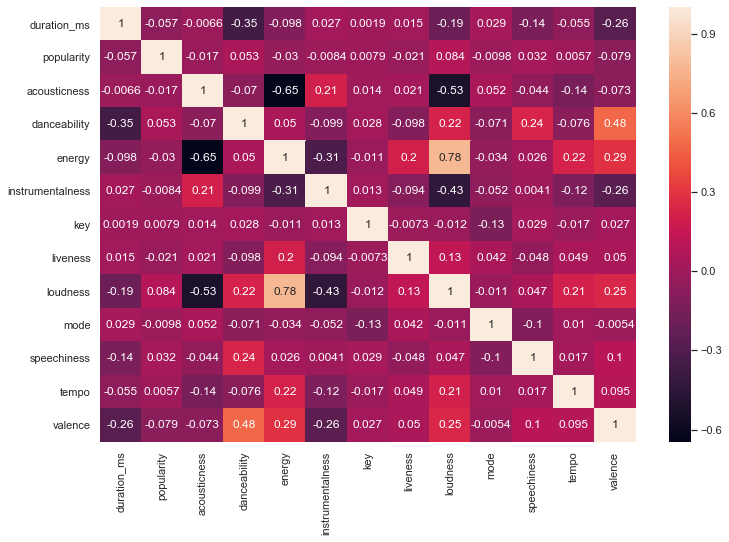

In [11]:
ax = sns.heatmap(df_songs.corr(), annot=True)
# Corrigindo erro da versão 3.1.1 do matplotlib
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

- Analisando as distribuições das variáveis numericas

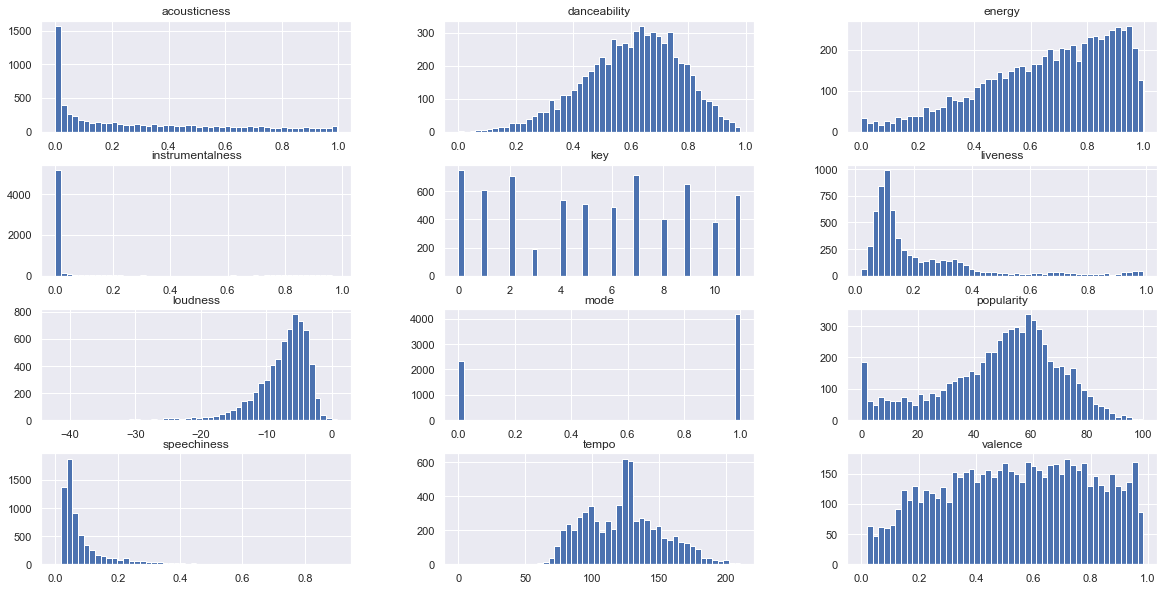

In [12]:
df_songs[['popularity', 'acousticness', 'danceability', 'energy', 
           'instrumentalness', 'key','liveness','loudness', 'mode', 'speechiness',
           'tempo', 'valence']].hist(bins=50, figsize=(20,10))
plt.show()

In [13]:
columns_to_cluster = ['popularity', 'acousticness', 'danceability', 
                      'energy', 'instrumentalness', 'liveness',
                      'loudness', 'speechiness', 'valence']

### Preprocessando os dados

- Mudando a escala dos dados

Usando Standard Scaler

In [20]:
# Atualmente usando o MinMaxScaler por gerar uma inertia menor no kMeans
ss = StandardScaler()

songs_scaled = ss.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = ss.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [-0.57611656  0.39351789  0.36662849  0.84929458 -0.40133461  0.42960597
  0.85456257 -0.65883238  1.54467758]
Dados de usuários:  [-0.019891   -0.84345475 -0.10896899  0.20583811 -0.44974244 -0.82975614
  0.18387081 -0.52882419 -0.7634763 ]


Usando Min Max Scaler

In [55]:
mms = MinMaxScaler()

songs_scaled = mms.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = mms.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [0.37       0.41264952 0.67889908 0.85982408 0.         0.30275798
 0.89108038 0.03362832 0.94817073]
Dados de usuários:  [7.97979798e-01 1.20120506e-01 3.57763975e-01 7.52439024e-01
 1.22871046e-04 7.27354664e-01 7.20101286e-01 7.56735341e-02
 1.65142550e-01]


- Heatmap scaled

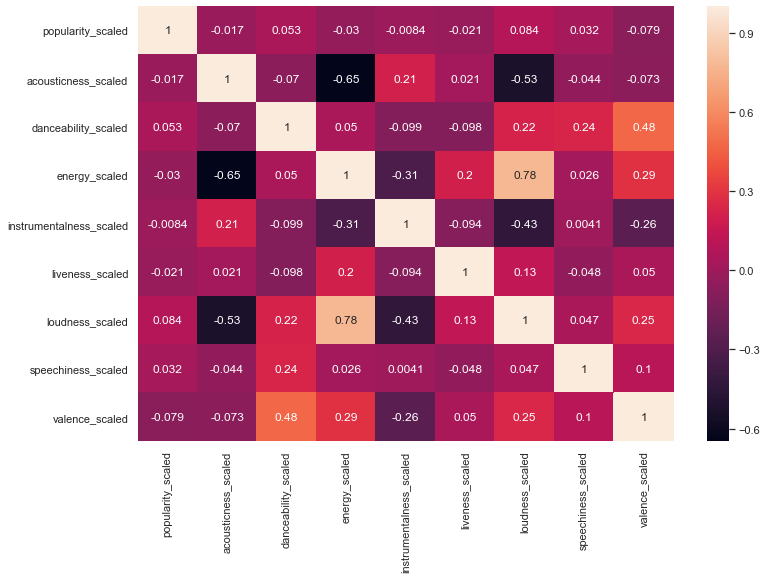

In [15]:
columns_to_cluster_scaled = ['popularity_scaled', 'acousticness_scaled', 'danceability_scaled', 
                             'energy_scaled', 'instrumentalness_scaled', 'liveness_scaled',
                             'loudness_scaled', 'speechiness_scaled', 'valence_scaled']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)
ax = sns.heatmap(df_songs_scaled.corr(), annot=True)
# Corrigindo erro da versão 3.1.1 do matplotlib
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Desenvolvendo o modelo

In [16]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.3012305504924181
Number of Clusters = 3, Silhouette Score = 0.1908176898953157
Number of Clusters = 4, Silhouette Score = 0.19726218949463145
Number of Clusters = 5, Silhouette Score = 0.21503754737025266
Number of Clusters = 6, Silhouette Score = 0.2243945887385722
Number of Clusters = 7, Silhouette Score = 0.1978978626228579
Number of Clusters = 8, Silhouette Score = 0.1994331570974855
Number of Clusters = 9, Silhouette Score = 0.19311115329932965
Number of Clusters = 10, Silhouette Score = 0.19205432814298462
Number of Clusters = 11, Silhouette Score = 0.18377165294535258
Number of Clusters = 12, Silhouette Score = 0.18209997187329122
Number of Clusters = 13, Silhouette Score = 0.16974953656314448
Number of Clusters = 14, Silhouette Score = 0.17616334711793058
Number of Clusters = 15, Silhouette Score = 0.15953366253903123
Number of Clusters = 16, Silhouette Score = 0.16498047377381875
Number of Clusters = 17, Silhouette Score = 0.1613225

- Silhouette score plot

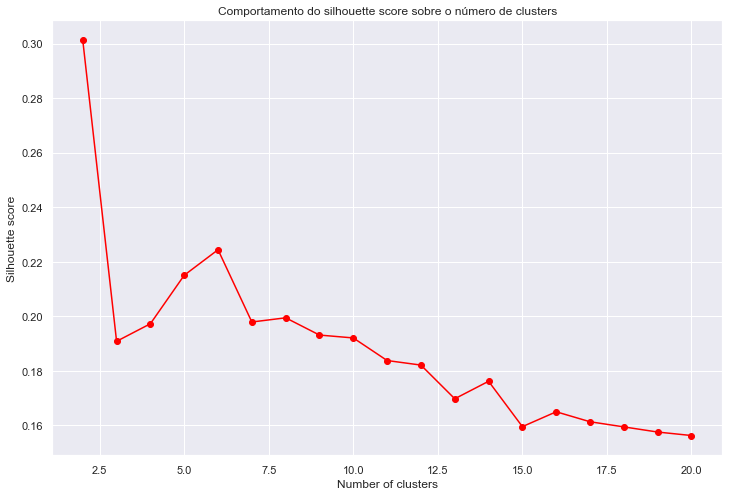

In [17]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Comportamento do silhouette score sobre o número de clusters')
plt.show()

- Elbow method plot

In [18]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 2054.478184043158
Number of Clusters = 3, Sum of Squared Distances = 1747.7117505662782
Number of Clusters = 4, Sum of Squared Distances = 1534.4945860038183
Number of Clusters = 5, Sum of Squared Distances = 1356.3322912391086
Number of Clusters = 6, Sum of Squared Distances = 1231.8743583363039
Number of Clusters = 7, Sum of Squared Distances = 1141.6010781122363
Number of Clusters = 8, Sum of Squared Distances = 1062.5578242896665
Number of Clusters = 9, Sum of Squared Distances = 1003.990169018867
Number of Clusters = 10, Sum of Squared Distances = 964.6402943933394
Number of Clusters = 11, Sum of Squared Distances = 925.5270046330388
Number of Clusters = 12, Sum of Squared Distances = 893.26074562849
Number of Clusters = 13, Sum of Squared Distances = 872.3399380237605
Number of Clusters = 14, Sum of Squared Distances = 849.4144367732132
Number of Clusters = 15, Sum of Squared Distances = 823.1591029292358
Number of Clusters = 16,

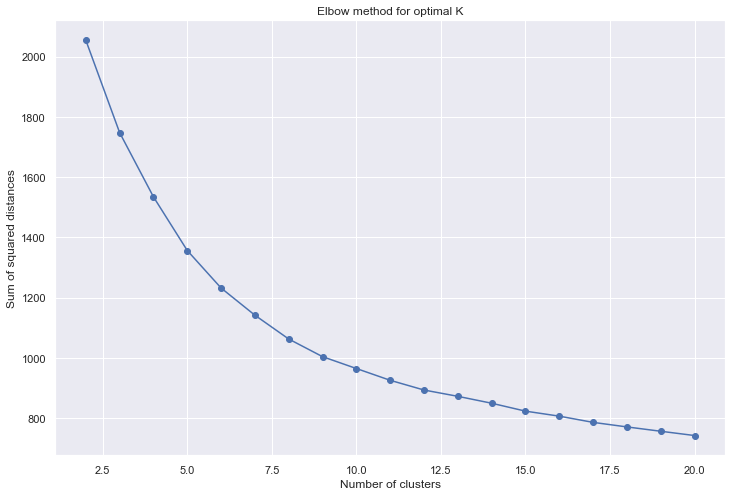

In [19]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [20]:
k=10

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 primeiros clusters: ', model.labels_[:10])

10 primeiros clusters:  [1 1 5 3 1 5 5 5 3 3]


### Visualizando os clusters

- Quantidade de músicas por cluster

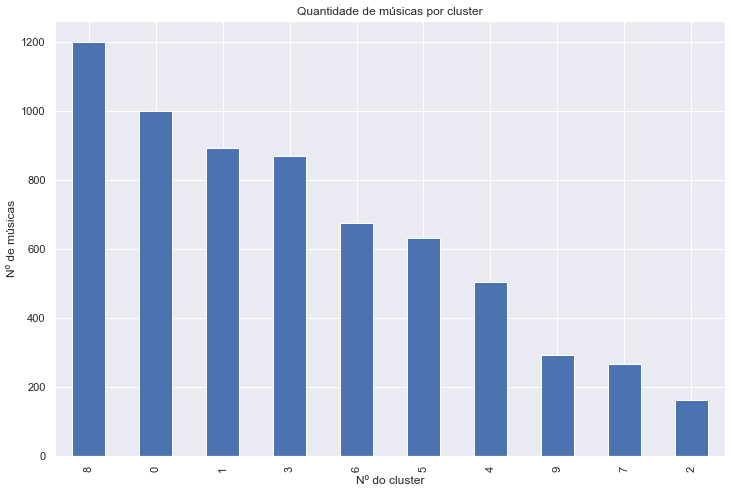

In [21]:
df_songs_scaled['cluster'] = model.labels_

df_songs_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Nº do cluster')
plt.ylabel('Nº de músicas')
plt.title('Quantidade de músicas por cluster')
plt.show()

In [22]:
display(df_songs_scaled['cluster'].value_counts())
minor_cluster = df_songs_scaled['cluster'].value_counts().tail(1)
print("Qtde. músicas no menor cluster: ", int(minor_cluster.values))

8    1201
0    1002
1     893
3     869
6     676
5     633
4     505
9     292
7     267
2     162
Name: cluster, dtype: int64

Qtde. músicas no menor cluster:  162


- Sample de músicas de cada cluster

In [23]:
df_songs_joined = pd.concat([df_songs,df_songs_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Staind,For You,Break The Cycle (Parental Advisory)
0,Of Mice & Men,Mushroom Cloud,Mushroom Cloud
0,Vicio,Fique em Paz,Fique em Paz
0,Train,Calling All Angels,My Private Nation
0,The Maine,"Heaven, We're Already Here",You Are OK
0,The Mönic,Frágil,Frágil
0,DMX,Party Up,...And Then There Was X
0,PNAU,Chameleon,Chameleon
0,Disaster Cities,Mice and Trash Cans,Lowa


,artist,name,album
cluster,,,
1,Matheusinho,Me Namora,Me Namora
1,Anastácia,Doce Cachaça,Daquele Jeito
1,Cartola,Festa Da Vinda,Cartola (1974)
1,Aviões do Forró,Chão Chão Chão - Ao Vivo,Aviões 10 Anos (Ao Vivo)
1,Toots & The Maytals,"Take Me Home, Country Roads",20th Century Masters: The Millennium Collectio...
1,Legião Urbana,Eduardo E Mônica,Mais Do Mesmo
1,Gabriel O Pensador,Sobrevivente,Sobrevivente
1,Creedence Clearwater Revival,Down On The Corner,Willy And The Poor Boys (40th Anniversary Edit...
1,Dona Ivone Lara,Prea comeu,Alegria minha gente (Terra dos meus sonhos dou...


,artist,name,album
cluster,,,
2,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Aria da capo - 1...",A State of Wonder: The Complete Goldberg Varia...
2,Bartolomeo Campagnoli,"Duet I in E Major, Op. 2: I. Allegro","Campagnoli: 6 Duos for Flute and Violin, Op. 2"
2,Franz Schubert,"String Quartet in D Minor, Op. posth. D.810 ""D...",Schubert: Der Tod und das Mädchen
2,Keaton Henson,Initium,Initium
2,Max Richter,Departure (Home),The Leftovers: Season 1 (Music from the HBO Se...
2,aqualina,april showers,april showers
2,Franz Schubert,"Piano Trio No.1 in B Flat, Op.99 D.898: 2. And...","Schubert: Piano Trio No. 1 (Trio Through Time,..."
2,Philip Glass,Etude No. 2,Etudes for Piano Vol 1 No. 1-10
2,Robert Schumann,"Schumann: Widmung, Op. 25 No. 1 (Arr. Liszt, S...",Love and Death - Widmung (Liebeslied)


,artist,name,album
cluster,,,
3,IZA,Saudade daquilo,Dona de mim
3,Post Malone,Staring At The Sun (feat. SZA),Hollywood's Bleeding
3,"Sarah, the Illstrumentalist",Multidimensional,All The Feels
3,Stage Rockers,That's The Way We Live It,That's The Way We Live It
3,P!nk,Just Give Me a Reason (feat. Nate Ruess),The Truth About Love
3,David Guetta,Better When You're Gone,Better When You're Gone
3,Recayd Mob,Sauce,Sauce
3,Black,Luto 2 (Temporais São Temporários),Luto 2 (Temporais São Temporários)
3,The Goo Goo Dolls,Name,A Boy Named Goo


,artist,name,album
cluster,,,
4,PH e Michel,Céu da Sua Boca - Ao Vivo,Rolê Diferente
4,Dominguinhos,Eu Só Quero um Xodó (Ao Vivo),Ao Vivo
4,Mr. Catra,Uh Papai Chegou / O Simpático - Ao Vivo,Mr. Catra 25 Anos (Ao Vivo)
4,Maiara & Maraisa,10% - Ao Vivo,Ao Vivo Em Campo Grande
4,Cavaleiros do Forró,Saideira - Ao Vivo,Cavaleiros Infinity
4,Sizzla,Wake Up,Wake Up - Single
4,Lauana Prado,Você Humilha - Ao Vivo Em São Paulo / 2018,Verdade (Ao Vivo Em São Paulo / 2018)
4,Diante do Trono,Te Agradeço - Ao Vivo,Diante do Trono (Ao Vivo)
4,May & Karen,Carro Chefe,Carro Chefe


,artist,name,album
cluster,,,
5,Dilsinho,Pouco a Pouco (Ao Vivo) - Acústico,Terra do Nunca (Acústico)
5,Elizeth Cardoso,Outra Vez,Legends Play Jobim
5,Adriana Calcanhotto,Devolva-Me (Ao Vivo),Público
5,Cynthia Luz,Me Negaram Amor,Me Negaram Amor
5,Trápala,Por um Verão Mais Gelado,A Mar É
5,The Brother Brothers,Siren Song,Siren Song
5,Whitney Houston,I Will Always Love You,The Bodyguard - Original Soundtrack Album
5,Courtney Hartman,Here's to the Ones,Ready Reckoner
5,Coldplay,The Scientist,A Rush of Blood to the Head


,artist,name,album
cluster,,,
6,Buzzcocks,Ever Fallen in Love (With Someone You Shouldn'...,Love Bites (Special Edition)
6,The Velvet Underground,Rock & Roll,Loaded: The Fully Loaded Edition
6,R.E.M.,Losing My Religion,Out Of Time (U.S. Version)
6,Whadi Gama,O Amor Me Pegou,O Amor Me Pegou
6,Sech,Que Mas Pues - Remix,Que Mas Pues (Remix)
6,Nan Dantas,Paquerinha,Paquerinha
6,Luan Estilizado,Ai Que Saudade d'ocê,Esquenta São João
6,Roberto Ribeiro,Todo Menino É Um Rei,Eu Sou O Samba - Roberto Ribeiro
6,Caio Costta,Papaizim Quer Namorar,No Sítio


,artist,name,album
cluster,,,
7,n o r m a l,cielo,cielo
7,Harris Cole,Blue and Green,Colors
7,Nymano,I Wish I Could Sleep,Chillhop Essentials Winter 2016
7,A L E X,This Week,"Growing Up, Vol. 2"
7,Made in M,Pero Asi,Chillhop Raw Cuts 2
7,s. lyre,home for a while,singing in my room
7,Gilberto Gil,O Pato,Gilbertos Samba
7,sagun,rains,yellow hills
7,Middle School,The Finish Line,The Finish Line


,artist,name,album
cluster,,,
8,Gonzaguinha,O Que É O Que É?,Caminhos Do Coração
8,Calcinha Preta,Amor de Mentira,Amor de Mentira
8,blink-182,I Miss You,blink-182
8,AC/DC,You Shook Me All Night Long,Who Made Who
8,Gusi,Ganas,Ganas
8,Engenheiros Do Hawaii,"Era um Garoto, Que Como Eu, Amava os Beatles e...",O Papa É Pop
8,DJ Dollynho Da Lapa,Surtada - Versão Funk,Surtada (Versão Funk)
8,Hobo Johnson,Mover Awayer,The Fall of Hobo Johnson
8,M-22,White Lies,White Lies


,artist,name,album
cluster,,,
9,Dream Child,Midnight Song,Until Death Do We Meet Again
9,Exodus,The Toxic Waltz,Fabulous Disaster
9,Green Velvet,WOW,WOW
9,FIILTH,Happy,Happy
9,Joy Division,Love Will Tear Us Apart - 2010 Remaster,Substance
9,Bakermat,Baianá,Baianá
9,Anti Up,Hey Pablo,Hey Pablo EP
9,Iggy Pop,Loves Missing,Free
9,LOthief,Dirty Talk,Dirty Talk


### Gráfico de radar de cada cluster

Feito com auxilio de:
- [jkwd - Favorite songs EDA.ipynb](https://github.com/jkwd/spotify/blob/master/Code/Favourite%20songs%20EDA.ipynb)
- [#392 Use faceting for Radar chart](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/)

In [24]:
rename_columns = dict(zip(columns_to_cluster_scaled,columns_to_cluster))

df_radar = df_songs_scaled.groupby('cluster')[columns_to_cluster_scaled].mean().reset_index().rename(columns=rename_columns)
df_radar

,cluster,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,0,0.442894,0.027260,0.475449,0.870100,0.029840,0.211703,0.859169,0.087378,0.354620
1,1,0.461142,0.541935,0.708920,0.655457,0.005143,0.157775,0.811701,0.109966,0.789476
2,2,0.416111,0.929595,0.287243,0.114068,0.819548,0.109660,0.450706,0.053215,0.132101
3,3,0.610046,0.190512,0.632481,0.560881,0.013755,0.132592,0.800107,0.104854,0.347444
4,4,0.494673,0.402561,0.588648,0.761340,0.005645,0.796676,0.832569,0.089466,0.618651
5,5,0.478942,0.759393,0.534204,0.337154,0.029784,0.137117,0.713958,0.063082,0.338757
6,6,0.201228,0.128241,0.698828,0.734975,0.012483,0.156023,0.821744,0.113309,0.767520
7,7,0.540375,0.652260,0.687688,0.320332,0.843196,0.136110,0.675845,0.146702,0.443515
8,8,0.630941,0.109003,0.691667,0.775325,0.015340,0.156369,0.848302,0.108345,0.744880
9,9,0.478801,0.043332,0.620690,0.791752,0.741118,0.198509,0.821592,0.083899,0.444606


In [25]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=12)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

NOMEAR CLUSTERS

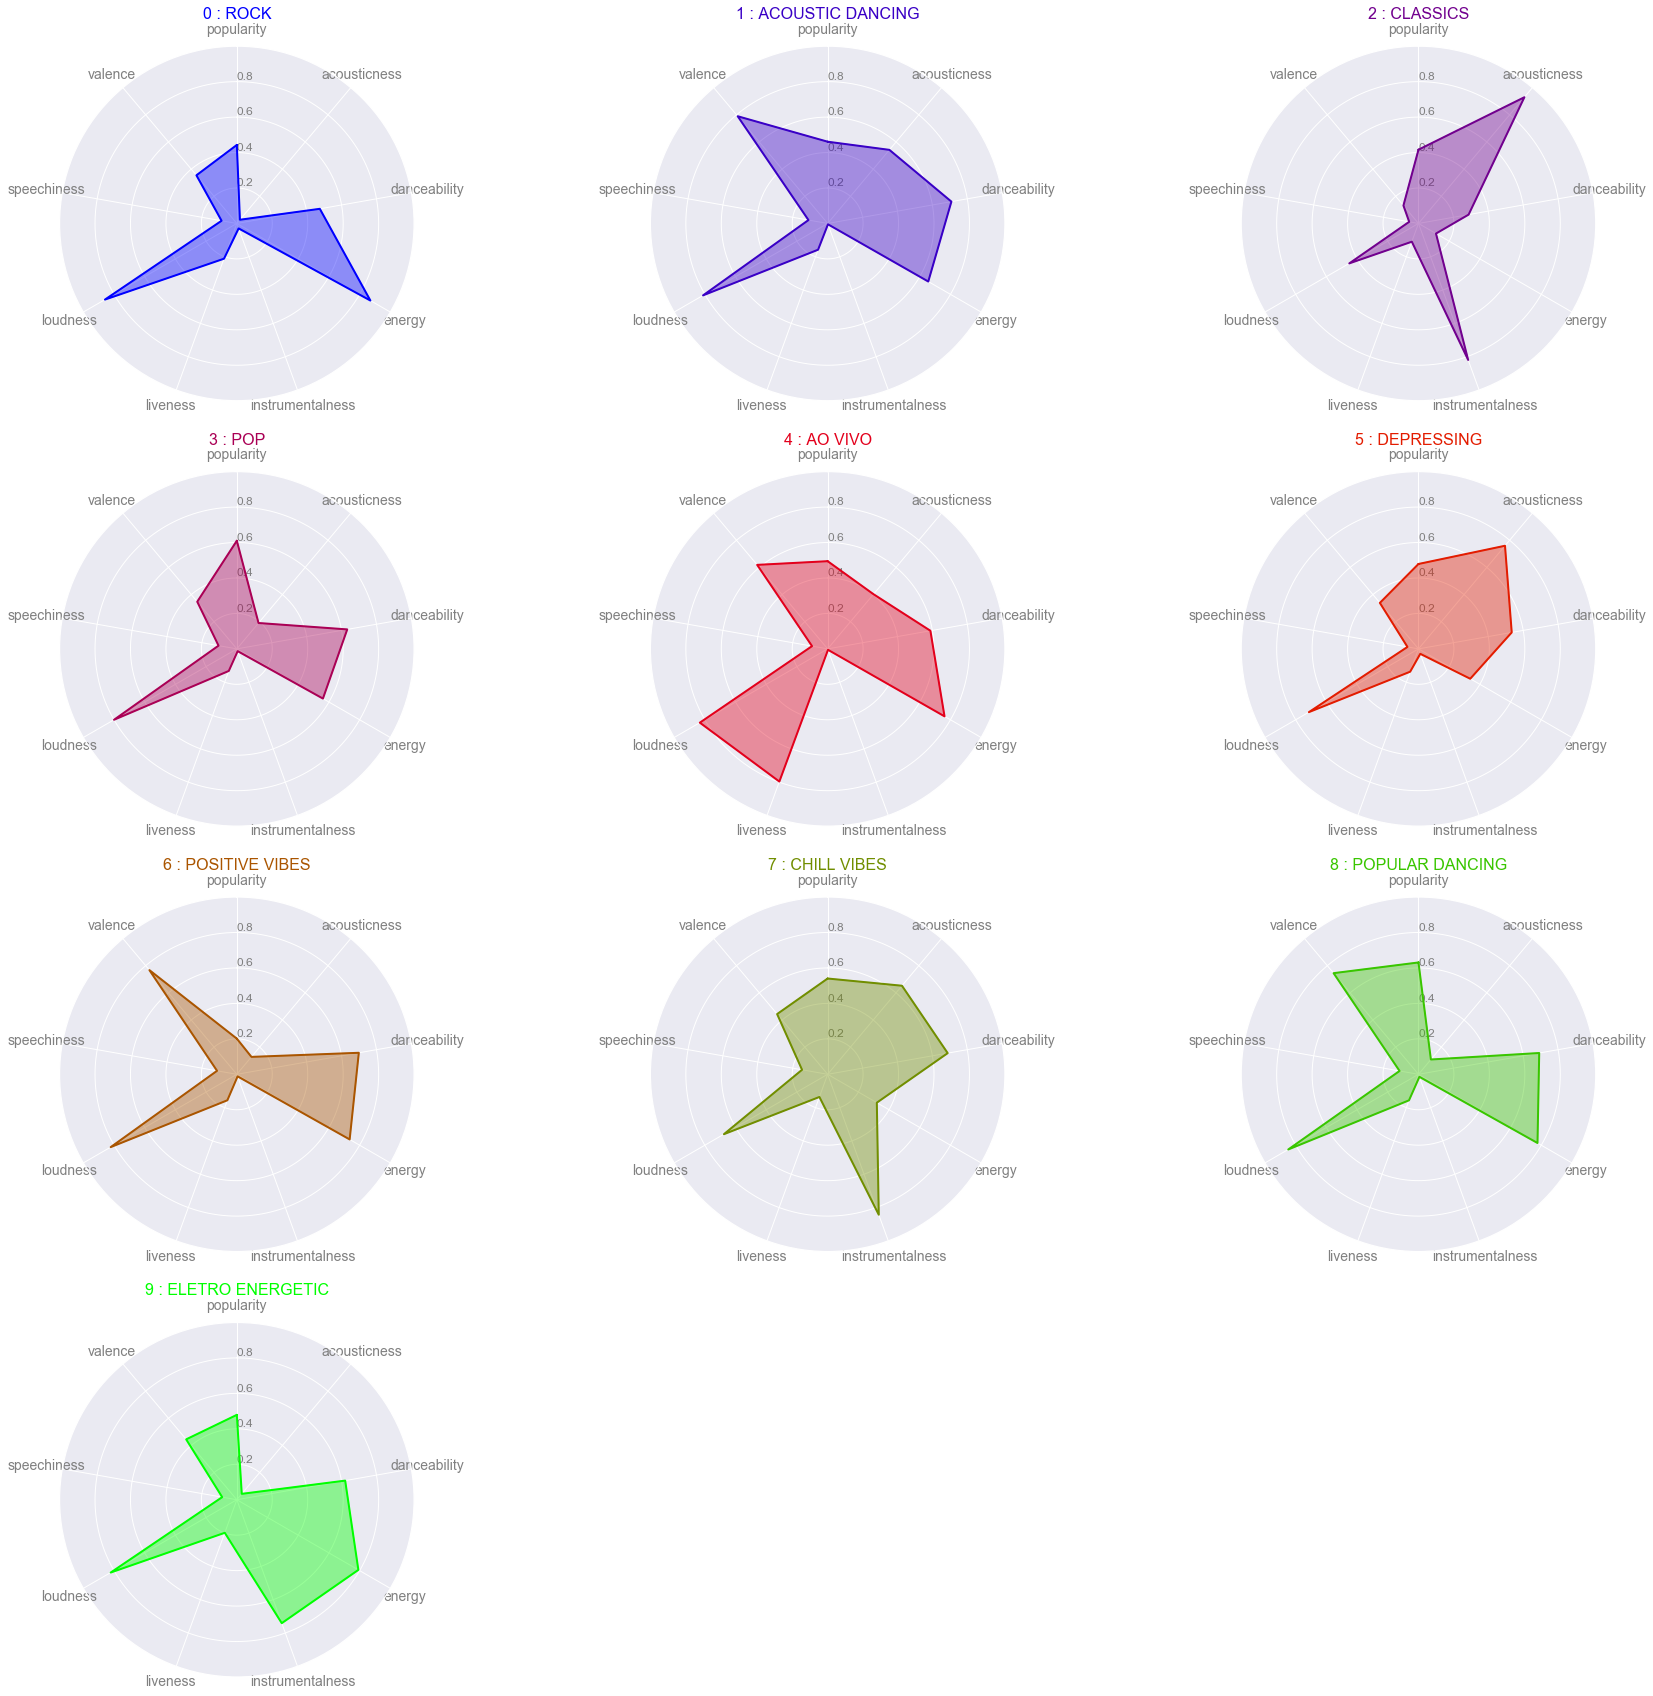

In [76]:
# initialize the figure
plt.figure(figsize=(30,30))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(df_radar.index))

# Create cluster name
title_list = ['ROCK', 'ACOUSTIC DANCING', 'CLASSICS', 'POP', 'AO VIVO', 
              'DEPRESSING', 'POSITIVE VIBES', 'CHILL VIBES', 'POPULAR DANCING', 'ELETRO ENERGETIC']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

### Aplicando PCA para visualizar os clusters

In [37]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.6612448741759883

In [38]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.216150,-0.396800,0.005520,1
1,-0.091717,-0.441951,-0.049434,1
2,0.757446,-0.008880,-0.266392,5
3,0.037356,0.043257,-0.021921,3
4,0.122819,-0.147323,0.043899,1


- Undersampling clusters

In [39]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

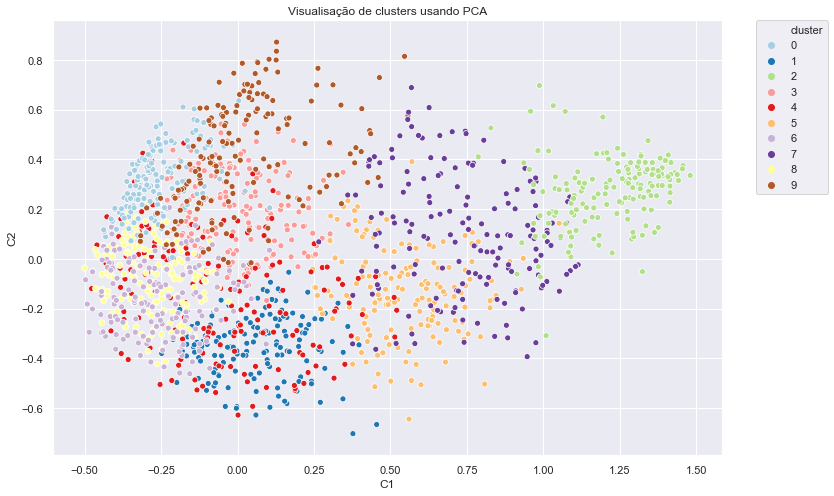

In [40]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando PCA')
plt.show()

- Scatter plot dos clusters em 3 dimensões

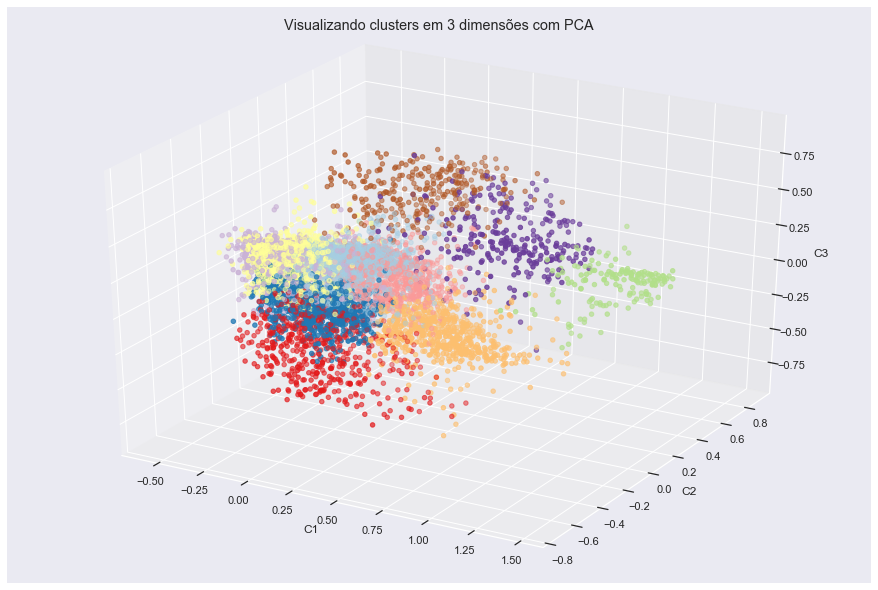

In [41]:
fig = plt.figure()
fig.suptitle('Visualizando clusters em 3 dimensões com PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

### Aplicando t-SNE para visualizar os clusters

In [149]:
#tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42, learning_rate=190)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [150]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-30.997292,31.497871,1
1,-32.823841,34.436462,1
2,25.035284,55.662899,5
3,14.640946,7.547970,3
4,8.820824,27.120035,1


- Undersampling clusters

In [151]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

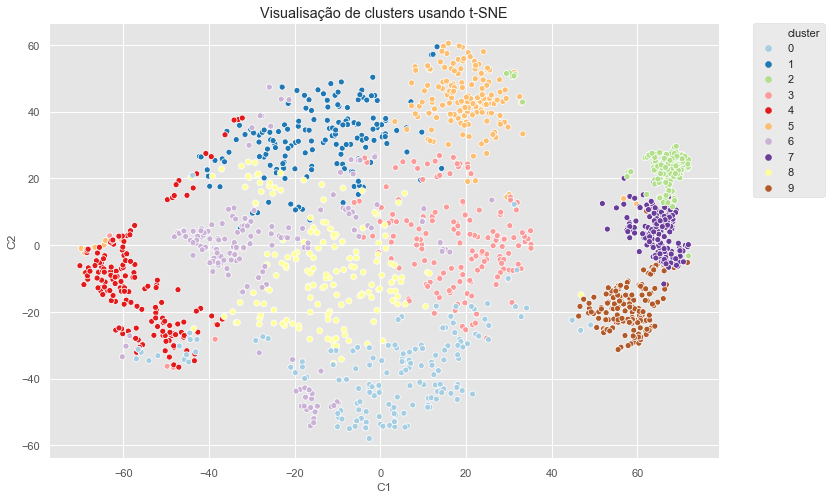

In [152]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando t-SNE')
plt.show()

### Prevendo os clusters do usuário

In [56]:
user_pred = model.predict(user_scaled)
print('10 primeiros clusters do usuário: ', user_pred[:10])

10 primeiros clusters do usuário:  [4 8 3 3 3 8 5 8 3 8]


- Quantidade de músicas do usuário por cluster

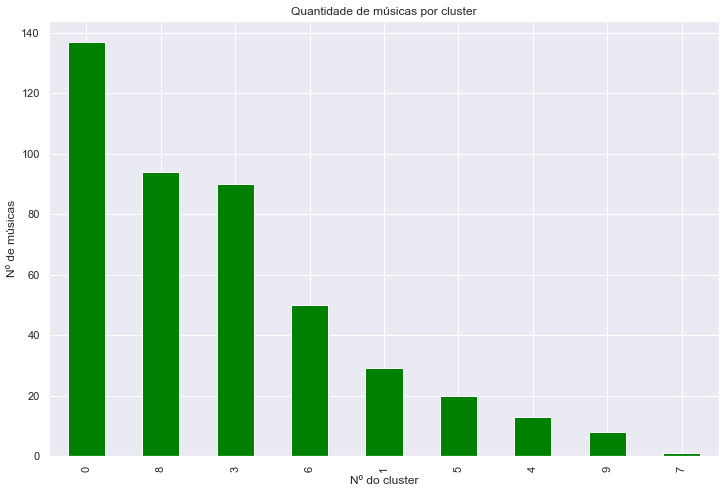

In [57]:
user_cluster = pd.DataFrame(user_scaled, columns=columns_to_cluster_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Nº do cluster')
plt.ylabel('Nº de músicas')
plt.title('Quantidade de músicas por cluster')
plt.show()

- Músicas presentes em cada cluster

In [58]:
df_user_songs_joined = pd.concat([df_user,user_cluster], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
4,Justin Timberlake,What Goes Around.../...Comes Around (Interlude),FutureSex/LoveSounds
4,Drake,Energy,If You're Reading This It's Too Late
4,Imagine Dragons,Radioactive,Night Visions
4,Backstreet Boys,Larger Than Life,Millennium
4,We Came As Romans,Hope,Tracing Back Roots
4,Beartooth,In Between,Disgusting
4,Eminem,Rap God,The Marshall Mathers LP2 (Deluxe)
4,Ludmilla,Favela chegou - Ao vivo,Hello mundo (Ao vivo)
4,Naiara Azevedo,Mentalmente,Mentalmente


,artist,name,album
cluster,,,
8,MC G15,Cara Bacana,Cara Bacana
8,Silverstein,Massachusetts,This Is How The Wind Shifts: Addendum
8,Jerry Smith,Troféu do Ano,Troféu do Ano
8,Jerry Smith,Kikadinha,Kikadinha
8,Ludmilla,Din Din Din (Participação especial de MC Pupio...,Din Din Din (Participação especial de MC Pupio...
8,50 Cent,21 Questions,Get Rich Or Die Tryin'
8,Mc 2k,Chupa *o*ota,MC 2K
8,MAGIC!,Rude,Don't Kill the Magic
8,Natasha Bedingfield,Pocketful of Sunshine,Pocketful Of Sunshine


,artist,name,album
cluster,,,
3,Offset,Ric Flair Drip (& Metro Boomin),Without Warning
3,Anitta,Veneno,Solo
3,Wiz Khalifa,Ass Drop,Blacc Hollywood
3,Beyoncé,Naughty Girl,Dangerously In Love
3,Diego Thug,Relaxa,Smoke Swag
3,Recayd Mob,Plaqtudum,Plaqtudum
3,Dynoro,In My Mind,In My Mind
3,DROELOE,In Time (feat. Belle Doron),In Time (feat. Belle Doron)
3,Travis Scott,BUTTERFLY EFFECT,ASTROWORLD


,artist,name,album
cluster,,,
5,MC Gustta,Abusadamente,Abusadamente
5,Ed Sheeran,I See Fire,x (Deluxe Edition)
5,Justin Bieber,Home To Mama,Home To Mama
5,Pentatonix,Hallelujah,A Pentatonix Christmas
5,Bullet For My Valentine,Breathe Underwater,Gravity
5,Lil Wayne,Mirror,Tha Carter IV (Deluxe)
5,MC Kevin o Chris,Ela É do Tipo,Ela É do Tipo
5,Mc Kevin,Pra Inveja É Tchau,Pra Inveja É Tchau
5,Dfideliz,Preto Rico,Preto Rico


,artist,name,album
cluster,,,
6,Anahí,Rumba,Inesperado
6,Eminem,When I'm Gone,Curtain Call (Deluxe)
6,Major Lazer,Get Free,Free the Universe (Extended Version)
6,Fergie,London Bridge,The Dutchess Deluxe
6,Drake,Hotline Bling,Hotline Bling
6,MC Menininho,Rabetão no Chão,Rabetão no Chão
6,Drake,Legend,If You're Reading This It's Too Late
6,MC Kevinho,Ta Tum Tum,Ta Tum Tum
6,Major Lazer,Powerful (feat. Ellie Goulding & Tarrus Riley),Peace Is The Mission


,artist,name,album
cluster,,,
1,Mc Don Juan,Amar Amei,Amar Amei
1,MC G15,Você Foi Diferente,Você Foi Diferente
1,Lexa,Chama Ela (feat. Pedro Sampaio),Chama Ela (feat. Pedro Sampaio)
1,MC Kevinho,Encaixa,Encaixa
1,Nego do Borel,Esqueci Como Namora,Esqueci Como Namora
1,MC D'Marco,Isso Que É Vida,Isso Que É Vida
1,MC Kevin o Chris,Finalidade Era Ficar em Casa,Finalidade Era Ficar em Casa
1,MCs Thin e Alexandre,Novinha Você É uma Flor,Novinha Você É uma Flor
1,Mc Davi,"Bonita, Lindinha e Sagaz","Bonita, Lindinha e Sagaz"


artist          MC Rafa 22
name      Ritmo do Pam Pam
album     Ritmo do Pam Pam
Name: 7, dtype: object

,artist,name,album
cluster,,,
0,STARSET,My Demons,Transmissions
0,I See Stars,Running With Scissors,Treehouse
0,The Amity Affliction,Born To Die,Chasing Ghosts (Special Edition)
0,Our Last Night,Road To The Throne,Younger Dreams
0,Beartooth,Aggressive,Aggressive
0,The Pussycat Dolls,When I Grow Up,Doll Domination (Revised International Version)
0,Bullet For My Valentine,All These Things I Hate (Revolve Around Me),The Poison (Deluxe Version)
0,Justin Bieber,Sorry,Purpose (Deluxe)
0,Beartooth,Me in My Own Head,Disgusting


,artist,name,album
cluster,,,
9,Dead by April,Playing With Fire,Worlds Collide
9,Secrets,Dance Of The Dead,Fragile Figures (Deluxe Edition)
9,For All Those Sleeping,Crosses,Incomplete Me
9,"Chunk! No, Captain Chunk!",The Other Line,"Get Lost, Find Yourself"
9,blessthefall,Hollow Bodies,Hollow Bodies
9,"Chunk! No, Captain Chunk!",The Other Line,"Get Lost, Find Yourself"
9,The Color Morale,Clip Paper Wings,Desolate Divine
9,Dead by April,Crying Over You,Worlds Collide


### Recomendando músicas

- Analisando as porcentagens de músicas por cluster

In [59]:
df_user_songs_joined.reset_index(inplace=True)
cluster_pct = df_user_songs_joined.cluster.value_counts(normalize=True)*100
display(cluster_pct)
print('Total de músicas: ', int(cluster_pct.round(0).sum()))

0    30.995475
8    21.266968
3    20.361991
6    11.312217
1     6.561086
5     4.524887
4     2.941176
9     1.809955
7     0.226244
Name: cluster, dtype: float64

Total de músicas:  100


In [60]:
df_songs_joined.reset_index(inplace=True)
df_songs_joined.head(3)

,level_0,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,0,0,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,...,0.933,0.37,0.412650,0.678899,0.859824,0.000000,0.302758,0.891080,0.033628,0.948171
1,1,1,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,...,0.871,0.38,0.566264,0.720693,0.851814,0.000095,0.319285,0.863885,0.035619,0.885163
2,2,2,5,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,...,0.180,0.00,0.804217,0.304791,0.158944,0.000000,0.041525,0.596297,0.039491,0.182927


- Adicionando a porcentagem ao dataset do usuário

In [61]:
df_user_songs_joined['cluster_pct'] = df_user_songs_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_songs_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_songs_joined.head(3)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,cluster_pct
0,4,Radioactive,62yJjFtgkhUrXktIoSjgP2,79,186813,Night Visions,6nxDQi0FeEwccEPJeNySoS,Imagine Dragons,53XhwfbYqKCa1cC15pYq2q,0.0634,...,1,0.6710,9,0.457,-3.699,0.11400,0.000101,0.793,136.382,2.941176
1,8,I Kissed A Girl,5gD1OfCiygqxjjOxiaEKUe,46,180946,I Kissed A Girl,6puf6DIqPoNJGxpr3oCR5s,Katy Perry,6jJ0s89eD6GaHleKKya26X,0.0932,...,0,0.0714,9,0.681,-3.230,0.00218,0.000000,0.753,129.976,21.266968
2,3,Roar,6F5c58TMEs1byxUstkzVeM,79,223546,PRISM (Deluxe),5MQBzs5YlZlE28mD9yUItn,Katy Perry,6jJ0s89eD6GaHleKKya26X,0.0418,...,0,0.3540,7,0.554,-4.821,0.00487,0.000007,0.772,179.984,20.361991


- Pegando amostras misturadas do dataset original e inserindo em uma nova playlist, baseada na porcentagem de músicas presente em cada cluster do usuário

In [62]:
playlist = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_songs_joined[df_songs_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    playlist = pd.concat([playlist,songs], ignore_index=True)
    if len(playlist) > 100 :
        flag = 100 - len(playlist)
        playlist = playlist[:flag]
playlist.head(3)

,level_0,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,6094,6094,0,Through The Looking Glass (Remastered And Expa...,7kEqVGkLoruahp34YW16oe,Siouxsie and the Banshees,1n65zfwYIj5kKEtNgxUlWb,309306,6EZDbjz2X5XzgIZCtbsrXh,The Passenger,...,0.2940,0.60,0.031022,0.465851,0.930913,0.000064,0.117860,0.874652,0.074447,0.298780
1,5151,5151,0,Yeshua + Só Quero Ver Você,4qzveuyWchP5wpVZ6PKm3O,Gui Brazil,5UBTjAZHVXlnISDDkj7LVE,258750,3QEqBKFS8boYIAELBcHUnj,Yeshua + Só Quero Ver Você (feat. Marcelo Markes),...,0.0373,0.40,0.001866,0.529052,0.775719,0.007444,0.036670,0.863816,0.038053,0.037907
2,5573,5573,0,Follow Your Heart,5rfBRcpVDCAMKA58iLabeB,Scorpions,27T030eWyCQRmDyuvr1kxY,245626,1EJZQ6uhrvl4JtoKn7RKFd,Follow Your Heart,...,0.1950,0.54,0.043271,0.359837,0.656569,0.000164,0.121992,0.847550,0.035288,0.198171


### EDA usuário vs nova playlist

In [63]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
level_0                    100 non-null int64
index                      100 non-null int64
cluster                    100 non-null int64
album                      100 non-null object
album_id                   100 non-null object
artist                     100 non-null object
artist_id                  100 non-null object
duration_ms                100 non-null int64
id                         100 non-null object
name                       100 non-null object
popularity                 100 non-null int64
acousticness               100 non-null float64
danceability               100 non-null float64
energy                     100 non-null float64
instrumentalness           100 non-null float64
key                        100 non-null int64
liveness                   100 non-null float64
loudness                   100 non-null float64
mode                       100 non-null int64
spee

In [64]:
playlist[['name', 'artist', 'album', 'cluster']]

,name,artist,album,cluster
0,The Passenger,Siouxsie and the Banshees,Through The Looking Glass (Remastered And Expa...,0
1,Yeshua + Só Quero Ver Você (feat. Marcelo Markes),Gui Brazil,Yeshua + Só Quero Ver Você,0
2,Follow Your Heart,Scorpions,Follow Your Heart,0
3,Shelter,Broken Bells,Shelter,0
4,Thrashed Relentlessly,Steel Prophet,Thrashed Relentlessly,0
...,...,...,...,...
95,Primeiros Erros (Chove) - Ao Vivo,Capital Inicial,Acústico Capital Inicial,4
96,Domingando - Ao Vivo,Thiaguinho,Domingando (Ao Vivo),4
97,Malbec (Part. Dennis Dj) - Ao Vivo,Henrique & Diego,Malbec (Part. Dennis Dj) [Ao Vivo],4
98,Got the Life,Korn,Follow The Leader,9


In [65]:
playlist.describe()

,level_0,index,cluster,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
count,100.000000,100.000000,100.00000,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3501.920000,3501.920000,3.56000,226988.88000,50.740000,0.165975,0.59523,0.727690,0.040986,5.590000,...,0.537783,0.507400,0.166640,0.606758,0.728349,0.041737,0.178885,0.826069,0.083113,0.546527
std,1959.020249,1959.020249,3.16968,64909.94548,19.721608,0.221032,0.15469,0.187801,0.138930,3.593189,...,0.236796,0.197216,0.221920,0.157686,0.188037,0.141477,0.173992,0.077812,0.079156,0.240647
min,87.000000,87.000000,0.00000,91416.00000,1.000000,0.000002,0.28600,0.219000,0.000000,0.000000,...,0.037300,0.010000,0.000000,0.291539,0.219020,0.000000,0.029129,0.497424,0.028208,0.037907
25%,1818.250000,1818.250000,0.00000,184219.75000,38.500000,0.002567,0.47125,0.571750,0.000000,2.000000,...,0.353750,0.385000,0.002576,0.480377,0.572213,0.000000,0.067762,0.795596,0.041455,0.359502
50%,3369.000000,3369.000000,3.00000,223143.50000,53.500000,0.067550,0.61250,0.747500,0.000007,6.000000,...,0.517000,0.535000,0.067820,0.624363,0.748184,0.000007,0.118376,0.843443,0.059071,0.525407
75%,5481.250000,5481.250000,6.00000,255191.25000,65.000000,0.264250,0.71800,0.904250,0.002060,8.000000,...,0.744500,0.650000,0.265310,0.731906,0.905131,0.002098,0.251885,0.876323,0.081305,0.756606
max,6454.000000,6454.000000,9.00000,461200.00000,100.000000,0.886000,0.90100,0.979000,0.967000,11.000000,...,0.971000,1.000000,0.889558,0.918451,0.979975,0.984725,0.954550,0.961829,0.551991,0.986789


- Comparar features entre user x playlist

In [66]:
def plot_recomendations_similarities(data, variables):
    root = int(np.ceil(np.sqrt(len(variables))))
    fig, axis = plt.subplots(nrows=root, ncols=root, figsize=(15, 15))
    
    numeric_categories = ["0.0 - 0.2",
                           "0.2 - 0.4",
                           "0.4 - 0.6",
                           "0.6 - 0.8",
                           "0.8 - 1.0",
                           ]
    fig.suptitle('Comparando distribuicoes para as caracteristicas das musicas')
    for idx, column in enumerate(variables):
        i, j = idx % root, idx // root
        ax = axis[j][i]
        
        grouped = data.groupby('user')[[column, 'user']]
        
        for user, group in grouped:
            sns.distplot(group[column], ax=ax, label=user, bins=20)
        ax.legend()
    plt.show()

In [67]:
df_user_songs_joined['user'] = 'User'
playlist['user'] = 'Playlist'

user = df_user_songs_joined.drop(columns='cluster_pct')

display(user.head(1))
playlist.head(1)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,user
0,4,Radioactive,62yJjFtgkhUrXktIoSjgP2,79,186813,Night Visions,6nxDQi0FeEwccEPJeNySoS,Imagine Dragons,53XhwfbYqKCa1cC15pYq2q,0.0634,...,1,0.671,9,0.457,-3.699,0.114,0.000101,0.793,136.382,User


,level_0,index,cluster,album,album_id,artist,artist_id,duration_ms,id,name,...,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled,user
0,6094,6094,0,Through The Looking Glass (Remastered And Expa...,7kEqVGkLoruahp34YW16oe,Siouxsie and the Banshees,1n65zfwYIj5kKEtNgxUlWb,309306,6EZDbjz2X5XzgIZCtbsrXh,The Passenger,...,0.6,0.031022,0.465851,0.930913,0.000064,0.11786,0.874652,0.074447,0.29878,Playlist


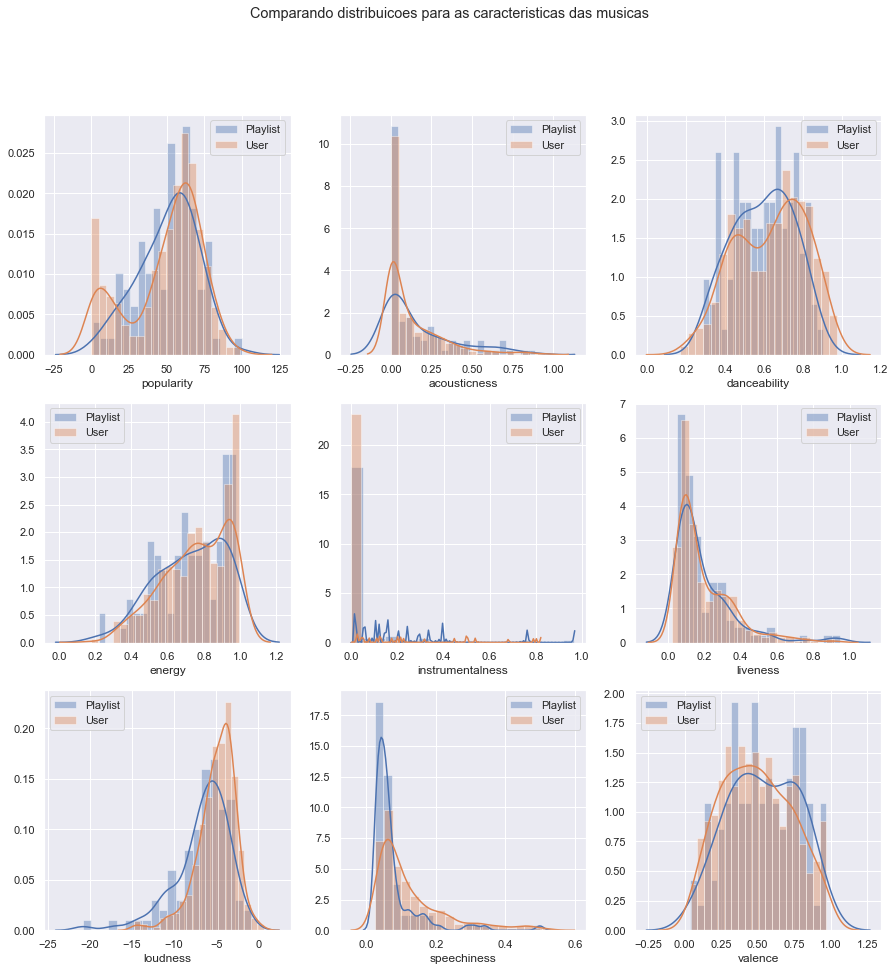

In [68]:
user_x_playlist = user.append(playlist)
plot_recomendations_similarities(user_x_playlist, columns_to_cluster)

### Exportando playlist gerada

- Para csv

In [69]:
playlist.drop(columns=columns_to_cluster_scaled, inplace=True)
playlist.to_csv('datasets/generated_playlists/brttrexpeita_playlist.csv', index=False)

- Para o Spotify

In [52]:
my_user = '12144777067'

session = SpotifySession(my_user)



         User authentication requires interaction with your
         web browser. Once you enter your credentials and
         give authorization, you will be redirected to
         a url.  Paste that url you were directed to to
         complete the authorization.

     
Opened https://accounts.spotify.com/authorize?client_id=f4bd9bcb87724721ab5b0a9667f1ae52&response_type=code&redirect_uri=https%3A%2F%2Fedujtm.github.io%2Fdiversify%2Fredirect&scope=playlist-modify-private+user-library-read in your browser


Enter the the code pattern you were given: AQBjpMJMSySFi_K5vjcpfz58rIvsaHIMOd0XguXCxtgy0ArKOz6GSQTUhCJnLDgv5t8ctMuWcNw5Yl3ncYSE9p8CFfMu9AfwgAv5LW0BWB7edQukIbObNK-c5VfY_1VbgKt5O7nbcLRhbTbRqByOzo0L_zPOxGk5BrnmMWvJGtbwuVGOzNbOdpyiFPyavqTJbYseqBHZaUC24u9NHtoHgTBaYWhkvMBLeS3lC6coIQEibFBsGcl7En8YUPmjf93cGZWPxOP6vsKCkhwrcf2t




In [70]:
session.tracks_to_playlist(trackids=playlist['id'], name='brtt Playlist')